In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/forgery-dataset/Forgery Dataset/valid/labels.cache
/kaggle/input/forgery-dataset/Forgery Dataset/valid/labels/image-5-_png_jpg.rf.e5780a684dd168381770ca4119dec735.txt
/kaggle/input/forgery-dataset/Forgery Dataset/valid/labels/image-5-_png_jpg.rf.ac3bc2b9ac58bae8422d870d746d0cfb.txt
/kaggle/input/forgery-dataset/Forgery Dataset/valid/labels/image-7-_png.rf.d7b2b4a701a414dd7d0295cea317d08c.txt
/kaggle/input/forgery-dataset/Forgery Dataset/valid/labels/image-5-_png.rf.d98fd2aca147040db84ac8145e74f10a.txt
/kaggle/input/forgery-dataset/Forgery Dataset/valid/labels/image-5-_png.rf.636a9b27d330102cf4477ce59ab5af1d.txt
/kaggle/input/forgery-dataset/Forgery Dataset/valid/labels/image-6-_png_jpg.rf.ef31b487d745dabe96c1b8704f0c78a3.txt
/kaggle/input/forgery-dataset/Forgery Dataset/valid/labels/image-7-_png.rf.9cee7faf44892d02c4c2f910852239b5.txt
/kaggle/input/forgery-dataset/Forgery Dataset/valid/labels/image-6-_png.rf.af3e4829b5cd5c2534de3e12709fd505.txt
/kaggle/input/forgery-datas

In [2]:
# Cell 1: Import necessary libraries and set device
import os
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.ops import box_iou
from PIL import Image

# Set device (Kaggle P100 GPU)
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device:", device)

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

CUDA Available: True
GPU Name: Tesla P100-PCIE-16GB
Using device: cuda


In [3]:
# Cell 2: Custom Dataset Class for YOLO format without JSON
def load_yolo_annotations(yolo_label_path, img_width, img_height):
    """
    Load YOLO-format annotations and convert to Faster R-CNN format.
    YOLO format: class, x_center, y_center, width, height (assume class is 0 for forgery, force label to 1).
    Returns: boxes (tensor, [N, 4]), labels (tensor, [N]).
    """
    if not os.path.exists(yolo_label_path):
        # If no label file, return empty
        return torch.tensor([], dtype=torch.float32).reshape(0, 4), torch.tensor([], dtype=torch.int64)

    boxes = []
    labels = []
    with open(yolo_label_path, 'r') as f:
        for line in f.readlines():
            values = line.strip().split()
            if len(values) < 5:
                continue
            _, x_center_norm, y_center_norm, width_norm, height_norm = map(float, values[:5])  # Ignore extra if any

            x_center = x_center_norm * img_width
            y_center = y_center_norm * img_height
            width_abs = width_norm * img_width
            height_abs = height_norm * img_height

            x_min = x_center - (width_abs / 2)
            y_min = y_center - (height_abs / 2)
            x_max = x_center + (width_abs / 2)
            y_max = y_center + (height_abs / 2)

            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(1)  # Label 1 for 'forgery' (adjust if multiple classes)

    return torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)

class ForgeryDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        self.img_dir = os.path.join(root_dir, split, "images")
        self.label_dir = os.path.join(root_dir, split, "labels")

        # List image files
        self.imgs = sorted([f for f in os.listdir(self.img_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
        self.ids = list(range(len(self.imgs)))  # Simple IDs based on index

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_filename = self.imgs[idx]
        img_path = os.path.join(self.img_dir, img_filename)

        image = Image.open(img_path).convert("RGB")
        img_width, img_height = image.size

        if self.transform:
            image = self.transform(image)

        label_filename = os.path.splitext(img_filename)[0] + ".txt"
        label_path = os.path.join(self.label_dir, label_filename)

        boxes, labels = load_yolo_annotations(label_path, img_width, img_height)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([self.ids[idx]])
        }
        return image, target

In [ ]:
# Cell 3: Define transforms and data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


dataset_root = '/kaggle/input/forgery-dataset/Forgery Dataset'  # Replace with actual path, e.g., '/kaggle/input/forgery-dataset'

# Create datasets
train_dataset = ForgeryDataset(root_dir=dataset_root, split='train', transform=transform)
val_dataset = ForgeryDataset(root_dir=dataset_root, split='valid', transform=transform)  # Assuming 'valid' folder
test_dataset = ForgeryDataset(root_dir=dataset_root, split='test', transform=transform)

# Create data loaders
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2, collate_fn=collate_fn)

# Test dataset loading
if len(train_dataset) > 0:
    image, target = train_dataset[0]
    print("Sample target:", target)
else:
    print("No images found in train dataset.")

Sample target: {'boxes': tensor([[141.5000, 318.5000, 205.5000, 348.5000],
        [153.0000, 274.0000, 214.0000, 303.0000]]), 'labels': tensor([1, 1]), 'image_id': tensor([0])}


In [5]:
# Cell 4: Model Definition
def get_model(num_classes):
    backbone = resnet_fpn_backbone('resnet50', pretrained=True)
    model = FasterRCNN(backbone, num_classes=num_classes)
    return model

# Assuming 2 classes: background + forgery (adjust if more classes)
num_classes = 2
model = get_model(num_classes)
model.to(device)




/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [6]:
# Cell 5: Training Function
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    running_loss = 0.0
    for images, targets in data_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch [{epoch}] Loss: {running_loss / len(data_loader):.4f}")

In [7]:
# Cell 6: Evaluation Function
def evaluate(model, data_loader, device):
    model.eval()
    iou_list = []
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            outputs = model(images)

            for target, output in zip(targets, outputs):
                gt_boxes = target["boxes"].to(device)
                pred_boxes = output["boxes"]
                if len(pred_boxes) > 0 and len(gt_boxes) > 0:
                    ious = box_iou(gt_boxes, pred_boxes)
                    iou_list.append(ious.max(dim=1)[0].mean().item())

    if iou_list:
        print(f"Average IoU: {np.mean(iou_list):.4f}")
    else:
        print("No detections for IoU calculation.")

In [8]:
# Cell 7: Train the model
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 100  # Adjust as needed

for epoch in range(1, num_epochs + 1):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    print("Validation:")
    evaluate(model, val_loader, device)

Epoch [1] Loss: 1.1974
Validation:
Average IoU: 0.0000
Epoch [2] Loss: 0.9610
Validation:
Average IoU: 0.0188
Epoch [3] Loss: 0.9195
Validation:
Average IoU: 0.0177
Epoch [4] Loss: 0.8501
Validation:
Average IoU: 0.0023
Epoch [5] Loss: 0.6916
Validation:
Average IoU: 0.0393
Epoch [6] Loss: 0.7024
Validation:
Average IoU: 0.0153
Epoch [7] Loss: 0.7570
Validation:
Average IoU: 0.0183
Epoch [8] Loss: 0.6595
Validation:
Average IoU: 0.0746
Epoch [9] Loss: 0.6099
Validation:
Average IoU: 0.1968
Epoch [10] Loss: 0.6091
Validation:
Average IoU: 0.0565
Epoch [11] Loss: 0.6040
Validation:
Average IoU: 0.1801
Epoch [12] Loss: 0.6315
Validation:
Average IoU: 0.3813
Epoch [13] Loss: 0.5602
Validation:
Average IoU: 0.2782
Epoch [14] Loss: 0.5670
Validation:
Average IoU: 0.1593
Epoch [15] Loss: 0.5552
Validation:
Average IoU: 0.3081
Epoch [16] Loss: 0.5441
Validation:
Average IoU: 0.3072
Epoch [17] Loss: 0.5229
Validation:
Average IoU: 0.3996
Epoch [18] Loss: 0.5465
Validation:
Average IoU: 0.3933
E

In [9]:
# Cell 8: Save the model
model_path = '/kaggle/working/forgery_fasterrcnn.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to /kaggle/working/forgery_fasterrcnn.pth


Test Set Evaluation:
Average IoU: 0.8292


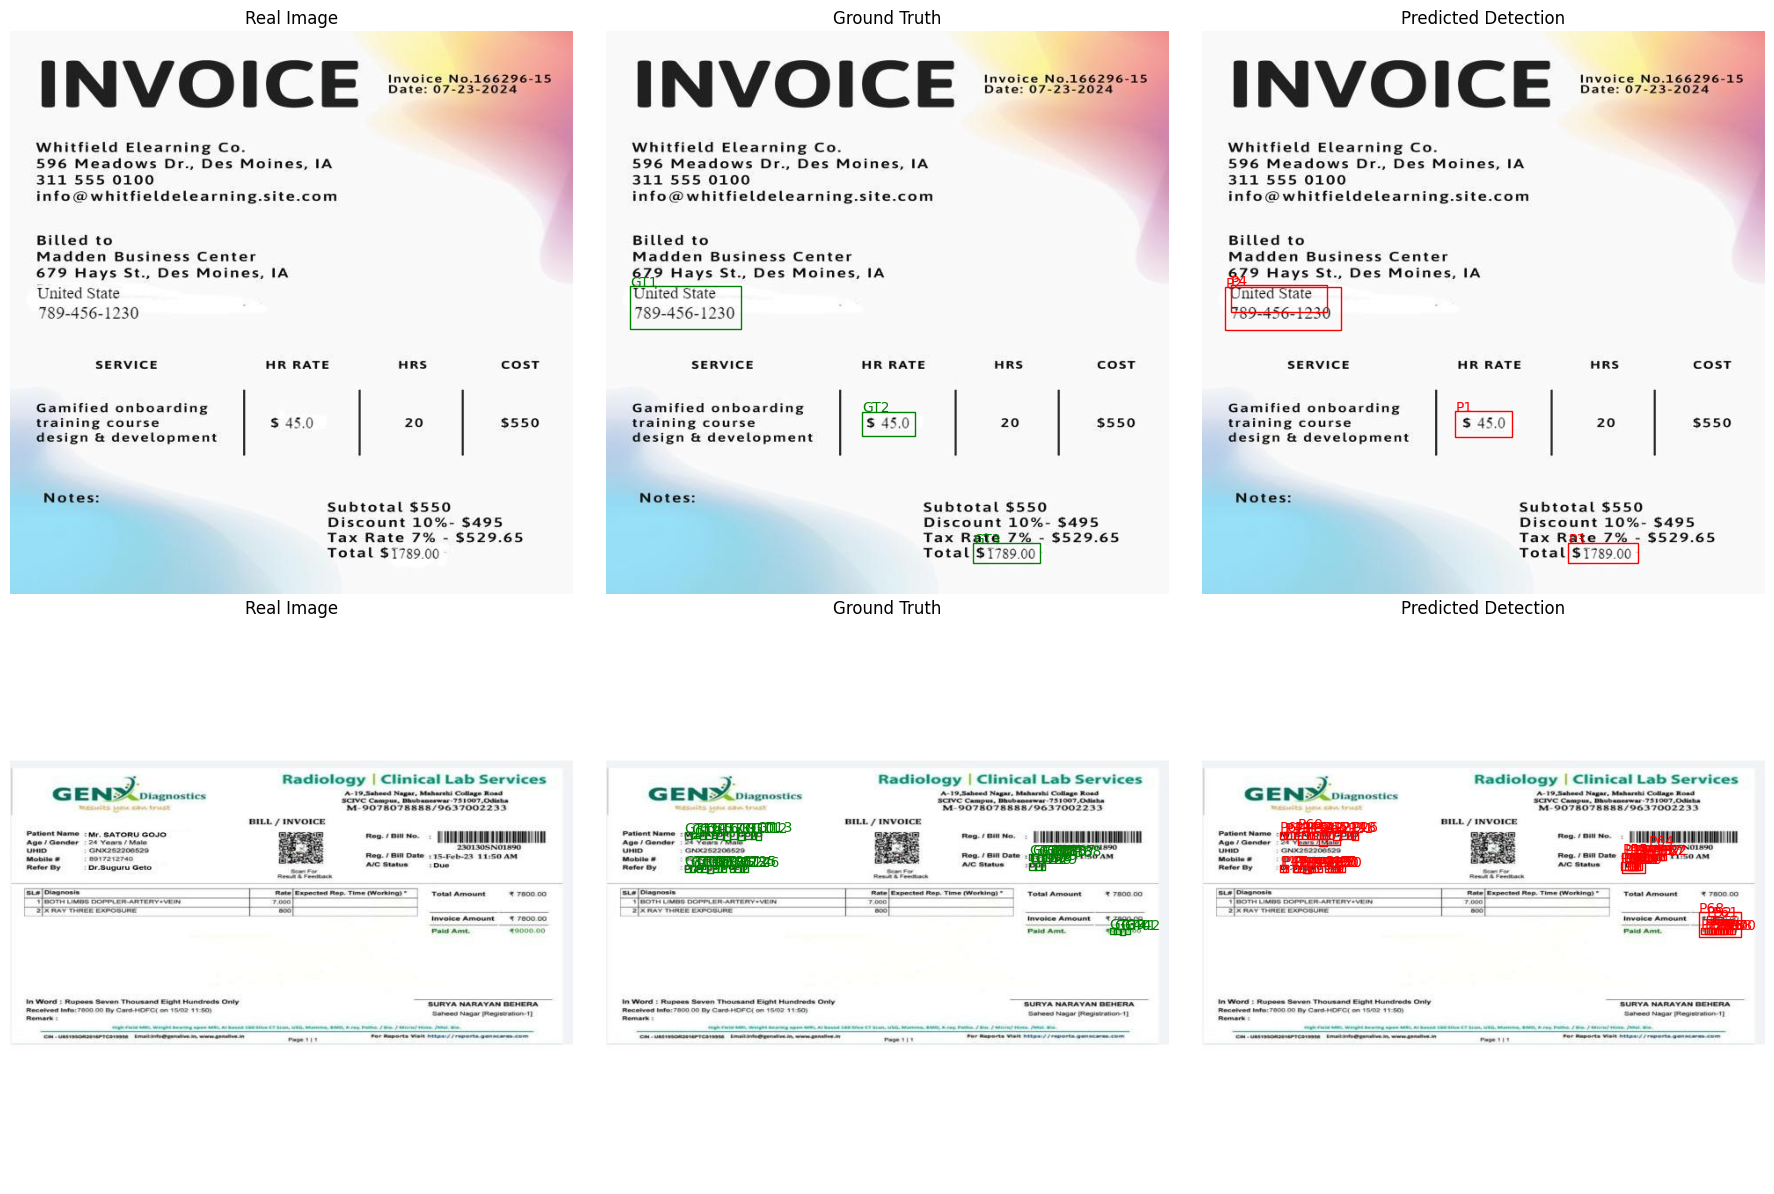

In [ ]:
# Cell 9: Inference and Visualization
def visualize_predictions(model, dataset, device, num_images=10):
    model.eval()
    indices = random.sample(range(len(dataset)), min(num_images, len(dataset)))
    fig, axes = plt.subplots(nrows=len(indices), ncols=3, figsize=(18, 6 * len(indices)))

    def draw_boxes(ax, boxes, color, label_prefix):
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1
            rect = patches.Rectangle((x1, y1), w, h, linewidth=1, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1, f"{label_prefix}{i+1}", color=color, fontsize=10, backgroundcolor="none")

    for idx_i, idx in enumerate(indices):
        image, target = dataset[idx]
        image_np = image.clone()
        image_np = image_np * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        image_np = image_np.permute(1, 2, 0).cpu().numpy()
        image_np = np.clip(image_np, 0, 1)

        # Real Image
        ax1 = axes[idx_i, 0] if len(indices) > 1 else axes[0]
        ax1.imshow(image_np)
        ax1.set_title("Real Image")
        ax1.axis("off")

        # Ground Truth
        ax2 = axes[idx_i, 1] if len(indices) > 1 else axes[1]
        ax2.imshow(image_np)
        ax2.set_title("Ground Truth")
        ax2.axis("off")
        draw_boxes(ax2, target["boxes"].cpu().numpy(), "g", "GT")

        # Predicted Detection
        ax3 = axes[idx_i, 2] if len(indices) > 1 else axes[2]
        ax3.imshow(image_np)
        ax3.set_title("Predicted Detection")
        ax3.axis("off")
        with torch.no_grad():
            pred = model([image.to(device)])[0]
        keep = pred['scores'] > 0.1
        pred_boxes = pred['boxes'][keep]
        draw_boxes(ax3, pred_boxes.cpu().numpy(), "r", "P")

    plt.tight_layout()
    plt.savefig('/kaggle/working/forgery_predictions.png')
    plt.show()

# Load saved model for inference
model.load_state_dict(torch.load(model_path))
model.to(device)

# Evaluate on test set
print("Test Set Evaluation:")
evaluate(model, test_loader, device)

# Visualize predictions on test images
visualize_predictions(model, test_dataset, device, num_images=2)